In [1]:
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy

In [2]:
import lalsimulation, lal

def generate_new_points(mass1, spin1x, npoints = 300, tstart = -0.1, tend = 0.005):
    chi1_l = 0
    chi2_l = 0
    chip = 0
    thetaJ = 0
    m1 = mass1
    distance = 5 * lal.PC_SI
    alpha0 = 0
    phic = 0
    f_ref = 100 * lal.HertzUnit,
    waveflags = lalsimulation.SimInspiralCreateWaveformFlags()
    approximant = lalsimulation.SimInspiralGetApproximantFromString("IMRPhenomP")
    #phorder = lalsimulation.SimInspiralGetOrderFromString("IMRPhenomP0")
    #f, ax = plt.subplots(10, sharey=True, figsize=(5,15))
    data = np.zeros((npoints, 4))
    mass1 = mass1 * lal.MSUN_SI
    coaphase = 0
    mass2 = 6 * lal.MSUN_SI
    spin1x, spin1y, spin1z = spin1x,0,0
    spin2x, spin2y, spin2z = 1,0,0
    flower = 10 
    fref = 10
    distance = 400 *1e6 * lal.PC_SI
    z = 0.0
    inclination = 0.0
    lambda1 = lambda2 = 0.0
    amporder = 0
    phorder = 0
    dt = (tend-tstart)/npoints
    hp, hc = lalsimulation.SimInspiralTD(coaphase, dt, 
                                         mass1, mass2,
                                         spin1x, spin1y, spin1z,
                                         spin2x, spin2y, spin2z,
                                         flower, fref, distance, z,
                                            inclination, lambda1, lambda2,
                                             waveflags, None, amporder, phorder,
                                         approximant
                                        )
    #-0.1,0.005
    times = np.linspace(0, len(hp.data.data)*hp.deltaT, len(hp.data.data)) + hp.epoch
    data[:,-1] =  hp.data.data[(tstart<times) & (times<tend)]
    data[:,0] = times[(tstart<times) & (times<tend)]
    data[:,1] = m1 * np.ones(npoints)
    data[:,2] = spin1x * np.ones(npoints)
    return data

In [3]:
bbh_data = generate_new_points(5, 0, npoints = 300) #np.vstack([generate_new_points(5, 0), generate_new_points(6, 0)])
bbh_test = generate_new_points(5, 0, npoints = 1000)

In [4]:
bbh = data.Data(np.atleast_2d(bbh_data[:,:1]), np.atleast_2d(bbh_data[:,-1]),  
                    target_names = ["Times"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test[:,:1],
                    test_labels = bbh_test[:,-1]
                    )

In [5]:
bbh.labels = np.squeeze(bbh.labels)

In [6]:
from heron import regression
from heron import kernels

In [7]:
x0 = [(1/np.std(bbh.labels))**2, 50]
gp = regression.Regressor(bbh, kernel=kernels.SquaredExponential(ndim=1), yerror = 1e-23, tikh=1e-6)
#p.set_hyperparameters(x0)

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [8]:
x0 = [ 32.57270317,  1/np.median(np.diff(bbh.targets.T[0])) ]
gp.set_hyperparameters(x0)

-1021.0598631009831

In [9]:
gp.optimise()

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/kernels.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


      fun: 441.26738922881316
 hess_inv: array([[   1.11359993,    3.68803054],
       [   3.68803054,  120.73155158]])
      jac: array([ 0.04247201,  1.13877905])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 89
      nit: 2
     njev: 77
   status: 2
  success: False
        x: array([  26.81246019,  111.63721573])

In [10]:
gp.correlation()

0.90000622812405773

In [11]:
gp.rmse()

8.2116732181286099e-23

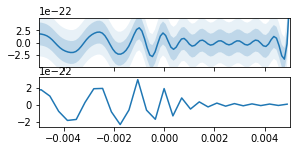

In [13]:
#test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_5d85_S0d25.txt')
f, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(4.5,2))
#test_point = 0
t = np.linspace(-0.1,0.005,1000)
new_point = np.zeros((1000,1))
#new_point[:,1] = 6
#new_point[:,2] = 0
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
ax[0].set_ylim([-.5e-21, .5e-21])
ax[0].set_xlim([-0.005, 0.005])
err = np.diag(pred[1])
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
#d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
#ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))
ax[1].plot(bbh_data[:,0], bbh_data[:,3])
plt.savefig('/home/daniel/thesis/figures/simplewave1.pgf')

In [8]:
bbh_data_2 = np.vstack([generate_new_points(5, 0), generate_new_points(10, 0), generate_new_points(15, 0)])
bbh_test_2 = np.vstack([generate_new_points(5, 0, 1000), generate_new_points(10, 0, 1000), generate_new_points(15, 0, 1000)])

In [9]:
bbh_2 = data.Data(bbh_data_2[:,:2], bbh_data_2[:,-1],
    #bbh_text[:,:2], bbh_text[:,-1],              
                    target_names = ["Times", "Mass"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test_2[:,:2],
                    test_labels = bbh_test_2[:,-1]
                    )

In [10]:
gp = regression.Regressor(bbh_2, kernel=kernels.SquaredExponential(ndim=2), yerror = 1e-23, tikh=1e-6)
x0 = [ (1/np.std(bbh_2.labels))**2,  1/np.median(np.diff(bbh_2.targets.T[0])), 3] #1/np.median(bbh_2.targets.T[1][::300])  ]
gp.set_hyperparameters(x0)
gp.optimise()

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/kernels.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


      fun: 3067.5907111936617
 hess_inv: array([[ 1.00040832,  0.02609609,  0.02950267],
       [ 0.02609609,  2.54159969,  1.9099292 ],
       [ 0.02950267,  1.9099292 ,  3.12694405]])
      jac: array([ 0.11512266,  6.08151529,  8.56469922])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 98
      nit: 1
     njev: 86
   status: 2
  success: False
        x: array([  40.95673868,  296.36339674,   -1.30633712])

In [14]:
gp

<Heron Gaussian Process instance with 900 training points>

In [44]:
gp.set_hyperparameters([  40.95673868,  296.36339674,   2.5])

-3250.4148783115302

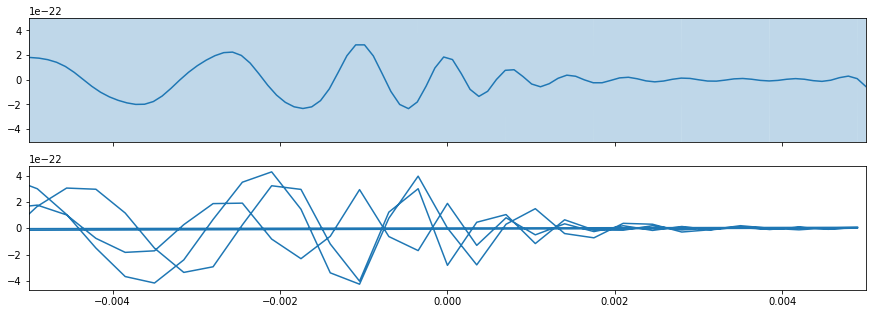

In [45]:
#test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_5d85_S0d25.txt')
f, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(15,5))
#test_point = 0
t = np.linspace(-0.1,0.005,1000)
new_point = np.zeros((1000,2))
new_point[:,1] = 5
#new_point[:,2] = 0
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
ax[0].set_ylim([-.5e-21, .5e-21])
ax[0].set_xlim([-0.005, 0.005])
err = np.diag(pred[1])
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
#d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
#ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))
ax[1].plot(bbh_data_2[:,0], bbh_data_2[:,3])

In [34]:
print gp.correlation()
print gp.rmse()

0.4401440383
6.95085128847e-23


In [52]:
bbh_data_3 = np.vstack([
                            generate_new_points(5, 0), generate_new_points(10, 0), generate_new_points(15, 0),
                            generate_new_points(5, .5), generate_new_points(10, .5), generate_new_points(15, .5),
                            generate_new_points(5, 1), generate_new_points(10, 1), generate_new_points(15, 1)
                       ])
bbh_test_3 = np.vstack([
                            generate_new_points(5, 0, 1000), generate_new_points(10, 0, 1000), generate_new_points(15, 0, 1000),
                            generate_new_points(5, .5, 1000), generate_new_points(10, .5, 1000), generate_new_points(15, .5, 1000),
                            generate_new_points(5, 1, 1000), generate_new_points(10, 1, 1000), generate_new_points(15, 1, 1000)
                       ])
bbh_3 = data.Data(bbh_data_3[:,:3], bbh_data_3[:,-1],
    #bbh_text[:,:2], bbh_text[:,-1],              
                    target_names = ["Times", "Mass"],
                    label_names = ["hp strain"],
                    test_size = 0,
                    test_targets = bbh_test_3[:,:3],
                    test_labels = bbh_test_3[:,-1]
                    )
gp = regression.Regressor(bbh_3, kernel=kernels.SquaredExponential(ndim=3), yerror = 1e-23, tikh=1e-6)
x0 = [ (1/np.std(bbh_3.labels))**2,  1/np.median(np.diff(bbh_3.targets.T[0])), 3, 3] #1/np.median(bbh_2.targets.T[1][::300])  ]
gp.set_hyperparameters(x0)
#gp.optimise()
gp.set_hyperparameters([47.25, 298, 1.69, 1.69])

-9635.9882629762124

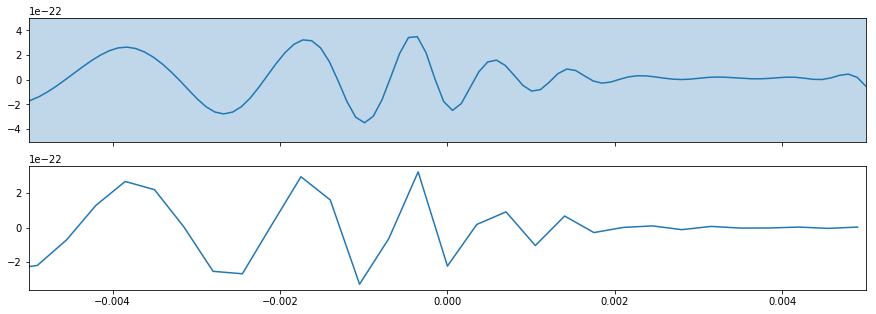

In [53]:
#test = np.genfromtxt('/home/daniel/data/imrphenom-test/bbh_mass1_only_hp_test_5d85_S0d25.txt')
f, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(15,5))
#test_point = 0
t = np.linspace(-0.1,0.005,1000)
new_point = np.zeros((1000,3))
new_point[:,1] = 10
new_point[:,2] = 0.9
new_point[:,0] = t
pred = gp.prediction(new_point)
ax[0].plot(t, pred[0])
ax[0].set_ylim([-.5e-21, .5e-21])
ax[0].set_xlim([-0.005, 0.005])
err = np.diag(pred[1])
err2 = err*1.96
ax[0].fill_between(t, pred[0] - err, pred[0] + err , alpha = 0.2)
ax[0].fill_between(t, pred[0] - err2, pred[0] + err2 , alpha = 0.1)
#d = test.T[0][1] - test.T[0][0]
#ax[0].plot(test.T[0]+d, test.T[2])
#ax[1].plot(t, np.sqrt((test.T[2] - pred[0])**2))
ax[1].plot(bbh_data_3[:,0][-600:-300], bbh_data_3[:,3][-600:-300])

In [54]:
gp.correlation()

0.44082045947341003

In [167]:
def match_factor(x, gp=gp, approximant = generate_new_points):
    """
    Calculate the match factor between the Gaussian Process and some other
    approximant. By default the IMRPhenomP approximant is used.
    
    Parameters
    ----------
    x : array-like
        The location at which the models should be compared.
    approximant : python callable
        The approximant to be used in the comparison.
    gp : heron hp object
        The Gaussian Process to be compared.
    """
    app = approximant(x[0], x[1], 300,  -0.005, 0.005)
    t = np.linspace(-0.005,0.005,300)
    new_point = np.zeros((300,3))
    new_point[:,1] = x[0]
    new_point[:,2] = x[1]
    new_point[:,0] = t
    pred = gp.prediction(new_point)
    plt.plot(app[:,3][:-10])
    plt.plot(np.roll(pred[0], -6)[:-10])
    app = app[:,3][:-10]
    pre = np.roll(pred[0], -6)[:-10]
    top = np.inner(pre, app)
    lb = np.sqrt(np.inner(app, app))
    rb = np.sqrt(np.inner(pre, pre))
    return top/(lb*rb)

In [132]:
match_factor([7.5,0.25], gp)

0.99803813597733948

In [147]:
def nei(m):
    return -gp.expected_improvement([0, m[0], m[1]])

class MyBounds(object):
     def __init__(self, xmax=[15,1], xmin=[5,0] ):
         self.xmax = np.array(xmax)
         self.xmin = np.array(xmin)
     def __call__(self, **kwargs):
         x = kwargs["x_new"]
         tmax = bool(np.all(x <= self.xmax))
         tmin = bool(np.all(x >= self.xmin))
         return tmax and tmin

from scipy.optimize import minimize
cons = [{'type':'ineq', 'fun': lambda x: x[1]>=0},
        {'type':'ineq', 'fun': lambda x: x[1]<1},
        {'type':'ineq', 'fun': lambda x: x[0]>7},
        {'type':'ineq', 'fun': lambda x: x[0]<15}]
bnds = ((5,15), (0,1))
def infill(number, gp):
    #x0 = [np.random.rand(),np.random.rand(),np.random.rand()]
    x0 = [10, 0]
    for i in range(number):
        mybounds = MyBounds()
        x0 = [10, 0.1]
        new = scipy.optimize.basinhopping(match_factor, x0, niter=100, accept_test=mybounds)
        #new = minimize(nei, x0, method='SLSQP',)#bounds = bnds)
        #target = bbh.denormalise(new.x, "target")
        print new.x
        target = new.x
        new_data = generate_new_points(target[0], target[1])
        gp.add_data(new_data[0,:3], new_data[0,-1])
        #gp.optimise()
        #return target, gp.loglikelihood()

In [149]:
x0 = [11,0]

-0.056960225548727705

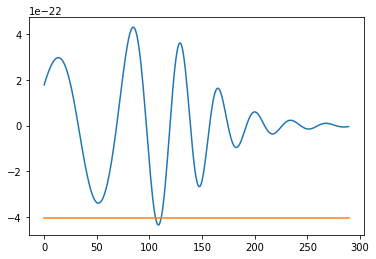

In [168]:
match_factor(x0)

In [157]:
n = 20
x = np.linspace(5, 15, n)
y = np.linspace(0,  1, n)
data = np.zeros((n,n))
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')
for i in range(n):
    for j in range(n):
        x0 = [ xv[i,j], yv[i,j] ]
        data[i][j] = match_factor(x0)

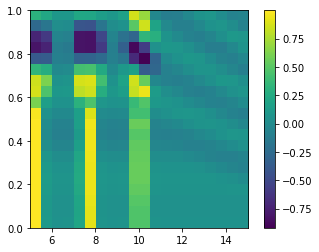

In [163]:
plt.imshow(data, extent=(5, 15, 0, 1), origin='lower left', aspect=10)
plt.colorbar()

0.99804468818635661

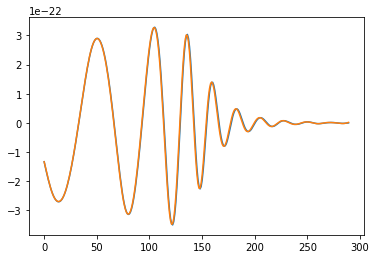

In [174]:
match_factor([7.5,0.5])

In [175]:
gp.kernel.flat_hyper

array([ 24.95395191,  21.95756258,  -2.07481906, -13.40978644])

In [16]:
x0 = [0.0005, 7, 6]
gp.expected_improvement(x0)

array([  1.95363131e-19])

In [17]:
gp.prediction(np.atleast_2d(x0))

(array([ -4.04570935e-22]), array([[  4.89195525e-19]]))

In [18]:
from scipy.optimize import minimize

In [19]:
t = np.linspace(-0.02,0.001,300)
m = np.linspace(5, 10, 300)
new_point = np.zeros((300,3))
new_point[:,1] = m
new_point[:,2] = 0
new_point[:,0] = 0

In [20]:
EI = map(gp.nei, new_point)

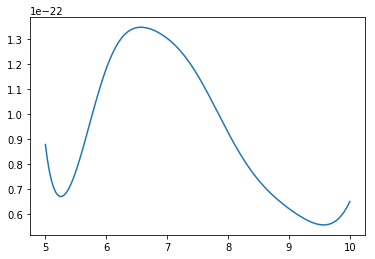

In [21]:
plt.plot(m, EI)

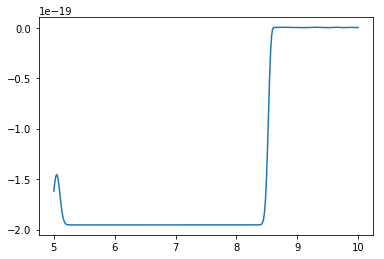

In [189]:
t = np.linspace(-0.02,0.001,300)
m = np.linspace(5, 10, 300)
new_point = np.zeros((300,3))
new_point[:,1] = 9.5
new_point[:,2] = 0
new_point[:,0] = t
EI = map(gp.nei, new_point)
plt.plot(m, EI)

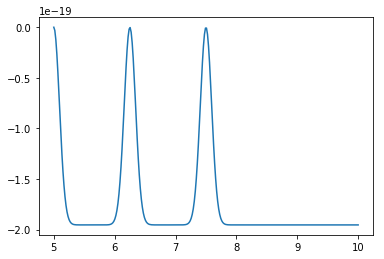

In [190]:
t = np.linspace(-0.02,0.001,300)
m = np.linspace(5, 10, 300)
s = np.linspace(0,1,300)
new_point = np.zeros((300,3))
new_point[:,1] = 9.5
new_point[:,2] = s
new_point[:,0] = 0
EI = map(gp.nei, new_point)
plt.plot(m, EI)

In [240]:
def nei(m):
    return -gp.expected_improvement([0, m[0], m[1]])

class MyBounds(object):
     def __init__(self, xmax=[15,1], xmin=[5,0] ):
         self.xmax = np.array(xmax)
         self.xmin = np.array(xmin)
     def __call__(self, **kwargs):
         x = kwargs["x_new"]
         tmax = bool(np.all(x <= self.xmax))
         tmin = bool(np.all(x >= self.xmin))
         return tmax and tmin

from scipy.optimize import minimize
cons = [{'type':'ineq', 'fun': lambda x: x[1]>0},
        {'type':'ineq', 'fun': lambda x: x[1]<1},
        {'type':'ineq', 'fun': lambda x: x[0]>0},
        {'type':'ineq', 'fun': lambda x: x[0]<1}]
bnds = ((5,15), (0,1))
def infill(number, gp):
    x0 = [np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in range(number):
        mybounds = MyBounds()
        x0 = [10, 0]
        new = scipy.optimize.basinhopping(nei, x0, niter=100, accept_test=mybounds)
        #new = minimize(nei, x0, method='SLSQP',)#bounds = bnds)
        #target = bbh.denormalise(new.x, "target")
        print new.x
        target = new.x
        new_data = generate_new_points(target[0], target[1])
        gp.add_data(new_data[0,:3], new_data[0,-1])
        #gp.optimise()
        #return target, gp.loglikelihood()

In [241]:
import scipy

In [242]:
class MyBounds(object):
     def __init__(self, xmax=[15,1], xmin=[5,0] ):
         self.xmax = np.array(xmax)
         self.xmin = np.array(xmin)
     def __call__(self, **kwargs):
         x = kwargs["x_new"]
         tmax = bool(np.all(x <= self.xmax))
         tmin = bool(np.all(x >= self.xmin))
         return tmax and tmin

In [243]:
infill(3, gp)

[ 9.69239827  0.87067163]
[ 9.85015422  0.77473381]
[ 9.9809669  0.745261 ]


In [51]:
np.append(a,b)

array([ -4.80007800e-03,   3.00000000e+01,   0.00000000e+00,
         1.63744136e+03])

In [47]:
np.append(a,b)

array([ -4.80007800e-03,   3.00000000e+01,   0.00000000e+00,
         1.62818153e+03])

In [25]:
gp.correlation()

0.010902684624271202

In [26]:
gp.rmse()

1.1603073805073734e-23

In [24]:
np.exp(gp.loglikelihood())

/home/daniel/.virtualenvs/heron/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


inf

In [20]:
gp.correlation()

0.010902683793309543

In [21]:
gp.prediction(np.atleast_2d(x0))

(array([ -2.92125616e-22]), array([[ -4.04570176e-22]]))

In [31]:
gp.expected_improvement([-0.015, 5.6])

0.0

In [32]:
y_min = gp.training_y.min()

In [36]:
x0 = [0, 9.5]
p, S = gp.prediction(np.atleast_2d(x0))

In [37]:
EI_one = ((y_min - p) * (0.5 + 0.5*m.erf((
          1./np.sqrt(2.))*((y_min - p) /
                           S))))
EI_two = ((S * (1. / np.sqrt(2. * np.pi))) * (np.exp(-(1./2.) *
                                                     ((y_min - p)**2. / S**2.))))
EI = EI_one + EI_two

In [38]:
EI

array([[ -8.87879249e-23]])

In [39]:
S

array([[ -3.66082381e-22]])